## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

import numpy as np
from collections import defaultdict
import torch
import urllib
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Load the datasets

We use the `Unified Multilingual Sentiment Analysis Benchmark` (UMSAB) dataset.






In [3]:
files = """test_labels.txt
test_text.txt
train_labels.txt
train_text.txt
val_labels.txt
val_text.txt""".split('\n')

In [4]:
def fetch_data(language, files):
 dataset = defaultdict(list)
 for infile in files:
   thisdata = infile.split('/')[-1].replace('.txt','')
   dataset_url = f"https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/{language}/{infile}"
   print(f'Fetching from {dataset_url}')
   with urllib.request.urlopen(dataset_url) as f:
     for line in f:
       if thisdata.endswith('labels'):
         dataset[thisdata].append(int(line.strip().decode('utf-8')))
       else:
         dataset[thisdata].append(line.strip().decode('utf-8'))
 return dataset

In [5]:
# Load the Hindi dataset
umsab_dataset = fetch_data('hindi', files)

Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/test_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/test_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/train_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/train_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/val_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/val_text.txt


In [6]:
train_text = umsab_dataset ['train_text']
train_labels = umsab_dataset ['train_labels']

val_text = umsab_dataset ['val_text']
val_labels = umsab_dataset ['val_labels']

test_text = umsab_dataset ['test_text']
test_labels = umsab_dataset ['test_labels']

## Encode the datasets

In [7]:
#MODEL = "cardiffnlp/twitter-xlm-roberta-base" # use this to finetune the language model
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment" # use this to finetune the sentiment classifier

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

In [9]:
train_encodings = tokenizer(train_text, truncation=True, padding=True)
val_encodings = tokenizer(val_text, truncation=True, padding=True)
test_encodings = tokenizer(test_text, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings,train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

## Define the parameters

In [11]:
LR = 2e-5
EPOCHS = 15
BATCH_SIZE = 32

## Fine-tuning

In order to create a model to fine-tune, we define the `TrainingArguments`/`TFTrainingArguments` and instantiate a `Trainer`/`TFTrainer`.

In [12]:
training_args = TrainingArguments(
    output_dir='./results',                   # output directory
    num_train_epochs=EPOCHS,                  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logs',                     # directory for storing logs
    logging_steps=10,                         # when to print log
    load_best_model_at_end=True,              # load or not best model at the end
    evaluation_strategy = "no",               # provided in order the evaluation and save strategy to match
    save_strategy = 'no'
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

In [13]:
trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    train_dataset=train_dataset,              # training dataset
    eval_dataset=val_dataset                  # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1839
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 870


Step,Training Loss
10,1.010600
20,1.064900
30,1.069000
40,1.043800
50,1.037600
60,1.083900
70,0.991100
80,0.952300
90,1.006500
100,1.028000




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=870, training_loss=0.3217346729014882, metrics={'train_runtime': 1164.8083, 'train_samples_per_second': 23.682, 'train_steps_per_second': 0.747, 'total_flos': 3628991814013440.0, 'train_loss': 0.3217346729014882, 'epoch': 15.0})

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

trainer.save_model("/content/gdrive/My Drive/Models/TXLMR/") # save best model

Saving model checkpoint to /content/gdrive/My Drive/Models/TXLMR/
Configuration saved in /content/gdrive/My Drive/Models/TXLMR/config.json


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Model weights saved in /content/gdrive/My Drive/Models/TXLMR/pytorch_model.bin


## Evaluate on Test set

In [15]:
test_preds_raw, test_labels , _ = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))

***** Running Prediction *****
  Num examples = 870
  Batch size = 32


              precision    recall  f1-score   support

           0      0.527     0.497     0.512       290
           1      0.418     0.455     0.436       290
           2      0.491     0.476     0.483       290

    accuracy                          0.476       870
   macro avg      0.479     0.476     0.477       870
weighted avg      0.479     0.476     0.477       870



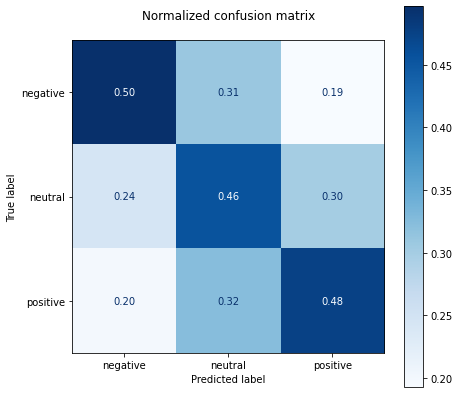

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
    plt.title("Normalized confusion matrix\n")
    plt.show()

plot_confusion_matrix(test_preds, test_labels, labels=['negative', 'neutral', 'positive'])

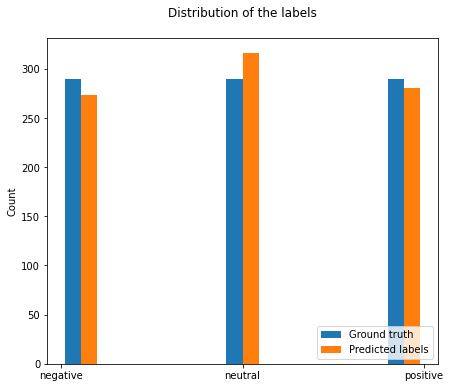

In [41]:
labels = ['negative', 'neutral', 'positive']
x = np.arange(len(labels))
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Distribution of the labels\n')
plt.hist([test_labels, test_preds], bins, label=['Ground truth', 'Predicted labels'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
plt.show()

<a id='ft_native'></a>